In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import os

x=np.empty([1000,28,28,3])
y=np.empty([1000,96])
g=np.empty([1000,96])
y_int=np.empty([1000])
g_int=np.empty([1000])

first = 1
for root, dirs, files in os.walk("/Users/momo/Downloads/openCV"):
	os.chdir(root)
	images = np.array([cv2.imread(file) for file in glob.glob(root+"/*.jpg")])
	num_of_images=images.shape[0]
	if num_of_images == 0:
		continue
	else:
		if first == 1:
			x = images
			name = os.path.basename(os.path.normpath(root))
			y.fill(0)
			num=0
			for i in range(0,999):
				y[i,num]=1
			y_int.fill(num)
			d={'strname':name,'intname':num}
			corr = pd.DataFrame(data = d,index=[num])
			first = 0
			num=num+1
		else:
			x = np.concatenate((x,images),axis=0)
			name = os.path.basename(os.path.normpath(root))
			g.fill(0)
			for i in range(0,999):
				g[i,num]=1
			y=np.concatenate((y,g),axis=0)
			g_int.fill(num)
			y_int=np.concatenate((y_int,g_int),axis=0)
			d={'strname' : name,'intname':num}
			newcorr = pd.DataFrame(data = d,index=[num])
			corr = corr.append(newcorr)
			num=num+1
x=np.reshape(x,[96000,2352])
#images=x
#labels=y
#print(num)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test,y_int_train,y_int_test = train_test_split(x, y, y_int, test_size=0.25, random_state=42)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [4]:
# The number of pixels in each dimension of an image.
img_size = 28

# The images are stored in one-dimensional arrays of this length.
img_size_flat = 2352

# Tuple with height and width of images used to reshape arrays.
img_shape = [28,28,3]

# Number of classes, one class for each of 10 digits.
num_classes = 96

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

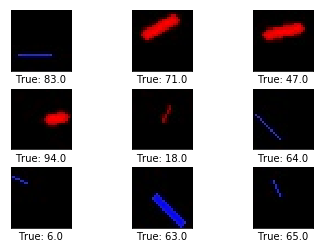

In [6]:
# Get the first images from the test-set.
images = x_test[0:9]

# Get the true classes for those images.
cls_true = y_int_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [7]:
print(corr.loc[[64]]) 
print(corr.loc[[65]])

    strname  intname
64  1_0_3_0       64
    strname  intname
65  0_0_4_0       65


In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [9]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [11]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [12]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
ex = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='ex')

In [14]:
x_image = tf.reshape(ex, [-1, img_size, img_size, num_channels])

In [15]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [16]:
y_true_cls = tf.argmax(y_true, axis=1)

In [17]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [19]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [20]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [21]:
num_features

1764

In [22]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [23]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [24]:
y_pred = tf.nn.softmax(layer_fc2)

In [25]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [26]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [27]:
cost = tf.reduce_mean(cross_entropy)

In [28]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.005).minimize(cost)

In [29]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [30]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [31]:
session = tf.Session()

In [32]:
session.run(tf.global_variables_initializer())

In [33]:
train_batch_size = 64

In [34]:
print(x_test.shape)

(24000, 2352)


In [35]:
def random_batch(x,y,y_int,batch_size):
        """
        Create a random batch of training-data.

        :param batch_size: Number of images in the batch.
        :return: 3 numpy arrays (x, y, y_cls)
        """
        num_train = 72000
        # Create a random index into the training-set.
        idx = np.random.randint(low=0, high=num_train, size=batch_size)

        # Use the index to lookup random training-data.
        x_batch = x[idx]
        y_batch = y[idx]
        y_int_batch = y_int[idx]

        return x_batch, y_batch, y_int_batch
        #return new_batch

In [36]:
#x_batch = random_batch(x_train,batch_size=train_batch_size)

In [37]:
#print(x_batch.shape)

In [38]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch,y_true_batch,_ = random_batch(x_train,y_train,y_int_train,batch_size=train_batch_size)
        
        #y_true_batch= random_batch(y_train,batch_size=train_batch_size)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {ex: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [39]:
ima = x_test[1:10, :]
lab = y_test[1:10, :]
#print(ima.shape)
#print(lab.shape)
feed_dict = {ex: ima, y_true: lab}

In [40]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = 24000

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = x_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {ex: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = y_int_test

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [41]:
print_test_accuracy()

Accuracy on Test-Set: 1.2% (298 / 24000)


In [42]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   7.8%
Time usage: 0:00:00


In [43]:
optimize(num_iterations=10000)

Optimization Iteration:    101, Training Accuracy:  39.1%
Optimization Iteration:    201, Training Accuracy:  79.7%
Optimization Iteration:    301, Training Accuracy:  90.6%
Optimization Iteration:    401, Training Accuracy:  89.1%
Optimization Iteration:    501, Training Accuracy:  98.4%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  84.4%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  95.3%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization I

In [44]:
print_test_accuracy()

Accuracy on Test-Set: 95.5% (22915 / 24000)
